In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
from scipy.spatial import Delaunay
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap
from scipy.io import loadmat

from skimage.segmentation import find_boundaries

## High AED

In [2]:
colormap_data = loadmat('cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])
hot2cold = ListedColormap(colormap_data['colormap'][::-1])

In [3]:
power_type = 'high_AED'

path = os.path.abspath(f'../../0_Moose_Files/{power_type}/exodus/')

model_path = path+'/FeNi.e'
model = netCDF4.Dataset(model_path)

In [4]:
# model.variables.keys()

In [ ]:
time_real = np.array(model.variables['time_whole'][:]).reshape((-1, ))
time_real

In [6]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
var_names = [b"".join(c).decode("latin1") for c in names[:]]
print("Node variables:", var_names)

Node variables: ['bnds', 'c', 'c1', 'c2', 'c3', 'cNi', 'eta1', 'eta2', 'eta3', 'eta4', 'eta5', 'temp', 'w']


In [6]:
def make_array_parallel(nodes, X_all, Y_all, param, blockname="Film", n_jobs=4, nx=500, ny=90,):
    start_time = time.time()
    
    # Convert to regular arrays in case they're masked
    x = np.asarray(X_all[nodes])
    y = np.asarray(Y_all[nodes])
    vals = np.asarray(param[:, nodes])  # shape (nt, nnodes_block)

    # Define structured target grid
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    Xi, Yi = np.meshgrid(xi, yi)

    nt = vals.shape[0]

    # Precompute Delaunay triangulation for linear interpolation
    tri = Delaunay(np.column_stack((x, y)))

    # Precompute nearest neighbor interpolator (used for NaNs)
    nearest_interp = NearestNDInterpolator(np.column_stack((x, y)), np.zeros_like(x))  # placeholder

    # Function to interpolate a single timestep
    def interp_timestep(t):
        field = vals[t, :]
        linear_interp = LinearNDInterpolator(tri, field)
        Zi = linear_interp(Xi, Yi)
        mask = np.isnan(Zi)
        if np.any(mask):
            Zi[mask] = NearestNDInterpolator(np.column_stack((x, y)), field)(Xi[mask], Yi[mask])
        return Zi

    # Parallel computation over time steps
    arr_list = Parallel(n_jobs=n_jobs)(delayed(interp_timestep)(t) for t in range(nt))
    arr = np.stack(arr_list, axis=2)

    # Flip once after the loop
    arr = np.flip(arr, axis=0)

    end_time = time.time()
    total_time = end_time - start_time

    # print(f"{blockname}: interpolated to shape {arr.shape}")
    print(f"Total time for {blockname}: {total_time:.2f} seconds")

    # return arr, Xi, Yi
    return arr

In [7]:
# comp, LIQ1, FCC2, BCC3, FCC4, BCC5 = [], [], [], [], [], []
parameters = ['vals_nod_var2', 'vals_nod_var7', 'vals_nod_var8', 'vals_nod_var9', 'vals_nod_var10', 'vals_nod_var11', 'vals_nod_var12']

nt, nnodes = model.variables[parameters[0]][:].shape
X_all = model.variables['coordx'][:]
Y_all = model.variables['coordy'][:]
# --- Connectivity: get block-specific nodes ---
connect1 = model.variables["connect1"][:] - 1   # film block
connect2 = model.variables["connect2"][:] - 1   # powder block
nodes_block1 = np.unique(connect1.ravel()).astype(int)
nodes_block2 = np.unique(connect2.ravel()).astype(int)

for i in range(7):
    param = model.variables[parameters[i]][:]
    if i == 0:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        comp=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 1:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        LIQ1=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 2:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        FCC2=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 3:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        BCC3=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 4:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        FCC4=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 5:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        BCC5=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    else:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        temp = np.flip(np.concatenate((powder, film), axis=0), axis=0)

print("Job Done")
model = 1

Total time for Powder: 2.43 seconds
Total time for Film: 3.55 seconds
Total time for Powder: 1.94 seconds
Total time for Film: 2.73 seconds
Total time for Powder: 2.03 seconds
Total time for Film: 5.04 seconds
Total time for Powder: 2.09 seconds
Total time for Film: 3.20 seconds
Total time for Powder: 2.02 seconds
Total time for Film: 4.79 seconds
Total time for Powder: 2.10 seconds
Total time for Film: 3.32 seconds
Total time for Powder: 2.01 seconds
Total time for Film: 3.59 seconds
Job Done


In [8]:
power_level = 'high' #'low'

numpy_path = os.path.abspath(f'../../1_Simulation_Results/numpy_files/{power_level}_power/')
np.save(numpy_path+'/comp.npy', comp)
np.save(numpy_path+'/LIQ1.npy', LIQ1)
np.save(numpy_path+'/FCC2.npy', FCC2)
np.save(numpy_path+'/BCC3.npy', BCC3)
np.save(numpy_path+'/FCC4.npy', FCC4)
np.save(numpy_path+'/BCC5.npy', BCC5)
np.save(numpy_path+'/temp.npy', temp)
np.save(numpy_path+'/time.npy', time_real)

In [9]:
time_real.shape

(462,)

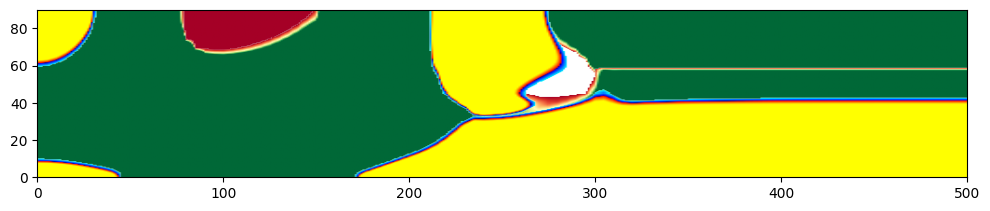

In [11]:
t_step = 200

fig, ax1 = plt.subplots(1,1, figsize=(12,8), frameon=True)

cmap =  plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(LIQ1[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.001, vmax=0.01, aspect=1, origin="lower", interpolation='bilinear')

cmap = plt.get_cmap('RdYlGn')
cmap.set_under('white', alpha=0)
hmap2a = ax1.imshow(FCC2[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.4, vmax=0.6, aspect=1, origin="lower", interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn')
cmap.set_under('white', alpha=0)
hmap2b = ax1.imshow(FCC4[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.01, vmax=0.05, aspect=1, origin="lower", interpolation='bilinear')

cmap=cold2hot
cmap.set_under('white', alpha=0) 
hmap3a = ax1.imshow(BCC3[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.4, vmax=0.6, aspect=1, origin="lower", interpolation='bilinear')
hmap3b = ax1.imshow(BCC5[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.4, vmax=0.6, aspect=1, origin="lower", interpolation='bilinear')

ax1.set_xlim(0, 500)
ax1.set_ylim(0, 90)

plt.show()
# fig.colorbar(ax1.images[0], ax=ax1, orientation='horizontal', label="Temperature")


## Low AED

In [12]:
colormap_data = loadmat('cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])
hot2cold = ListedColormap(colormap_data['colormap'][::-1])

In [13]:
power_type = 'low_AED' #low_power

path = os.path.abspath(f'../../0_Moose_Files/{power_type}/exodus/')

model_path = path+'/FeNi.e'
model = netCDF4.Dataset(model_path)

In [14]:
# model.variables.keys()

In [15]:
time_real = np.array(model.variables['time_whole'][:]).reshape((-1, ))


In [16]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
var_names = [b"".join(c).decode("latin1") for c in names[:]]
print("Node variables:", var_names)

Node variables: ['bnds', 'c', 'c1', 'c2', 'c3', 'cNi', 'eta1', 'eta2', 'eta3', 'eta4', 'eta5', 'temp', 'w']


In [17]:
def make_array_parallel(nodes, X_all, Y_all, param, blockname="Film", n_jobs=4, nx=500, ny=90,):
    start_time = time.time()
    
    # Convert to regular arrays in case they're masked
    x = np.asarray(X_all[nodes])
    y = np.asarray(Y_all[nodes])
    vals = np.asarray(param[:, nodes])  # shape (nt, nnodes_block)

    # Define structured target grid
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    Xi, Yi = np.meshgrid(xi, yi)

    nt = vals.shape[0]

    # Precompute Delaunay triangulation for linear interpolation
    tri = Delaunay(np.column_stack((x, y)))

    # Precompute nearest neighbor interpolator (used for NaNs)
    nearest_interp = NearestNDInterpolator(np.column_stack((x, y)), np.zeros_like(x))  # placeholder

    # Function to interpolate a single timestep
    def interp_timestep(t):
        field = vals[t, :]
        linear_interp = LinearNDInterpolator(tri, field)
        Zi = linear_interp(Xi, Yi)
        mask = np.isnan(Zi)
        if np.any(mask):
            Zi[mask] = NearestNDInterpolator(np.column_stack((x, y)), field)(Xi[mask], Yi[mask])
        return Zi

    # Parallel computation over time steps
    arr_list = Parallel(n_jobs=n_jobs)(delayed(interp_timestep)(t) for t in range(nt))
    arr = np.stack(arr_list, axis=2)

    # Flip once after the loop
    arr = np.flip(arr, axis=0)

    end_time = time.time()
    total_time = end_time - start_time

    # print(f"{blockname}: interpolated to shape {arr.shape}")
    print(f"Total time for {blockname}: {total_time:.2f} seconds")

    # return arr, Xi, Yi
    return arr

In [18]:
# comp, LIQ1, FCC2, BCC3, FCC4, BCC5 = [], [], [], [], [], []
parameters = ['vals_nod_var2', 'vals_nod_var7', 'vals_nod_var8', 'vals_nod_var9', 'vals_nod_var10', 'vals_nod_var11', 'vals_nod_var12']

nt, nnodes = model.variables[parameters[0]][:].shape
X_all = model.variables['coordx'][:]
Y_all = model.variables['coordy'][:]
# --- Connectivity: get block-specific nodes ---
connect1 = model.variables["connect1"][:] - 1   # film block
connect2 = model.variables["connect2"][:] - 1   # powder block
nodes_block1 = np.unique(connect1.ravel()).astype(int)
nodes_block2 = np.unique(connect2.ravel()).astype(int)

for i in range(7):
    param = model.variables[parameters[i]][:]
    if i == 0:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        comp=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 1:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        LIQ1=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 2:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        FCC2=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 3:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        BCC3=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 4:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        FCC4=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    elif i == 5:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        BCC5=np.flip(np.concatenate((powder, film), axis=0), axis=0)
    else:
        powder = make_array_parallel(nodes_block2, X_all, Y_all, param, blockname="Powder", n_jobs=6)
        film = make_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=6)
        temp = np.flip(np.concatenate((powder, film), axis=0), axis=0)

print("Job Done")
model = 1

Total time for Powder: 1.76 seconds
Total time for Film: 4.31 seconds
Total time for Powder: 1.61 seconds
Total time for Film: 3.08 seconds
Total time for Powder: 1.67 seconds
Total time for Film: 2.90 seconds
Total time for Powder: 1.66 seconds
Total time for Film: 4.56 seconds
Total time for Powder: 1.67 seconds
Total time for Film: 2.74 seconds
Total time for Powder: 1.64 seconds
Total time for Film: 2.21 seconds
Total time for Powder: 1.61 seconds
Total time for Film: 3.07 seconds
Job Done


In [19]:
power_level = 'low' #'low'
numpy_path = os.path.abspath(f'../../1_Simulation_Results/numpy_files/{power_level}_power/')
np.save(numpy_path+'/comp.npy', comp)
np.save(numpy_path+'/LIQ1.npy', LIQ1)
np.save(numpy_path+'/FCC2.npy', FCC2)
np.save(numpy_path+'/BCC3.npy', BCC3)
np.save(numpy_path+'/FCC4.npy', FCC4)
np.save(numpy_path+'/BCC5.npy', BCC5)
np.save(numpy_path+'/temp.npy', temp)
np.save(numpy_path+'/time.npy', time_real)

In [20]:
time_real.shape

(427,)

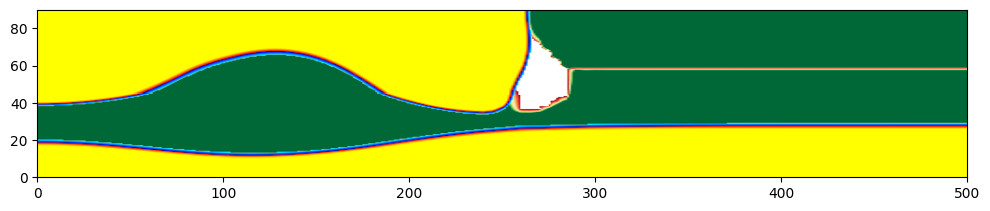

In [21]:
t_step = 200

fig, ax1 = plt.subplots(1,1, figsize=(12,8), frameon=True)

cmap =  plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(LIQ1[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.001, vmax=0.01, aspect=1, origin="lower", interpolation='bilinear')

cmap = plt.get_cmap('RdYlGn')
cmap.set_under('white', alpha=0)
hmap2a = ax1.imshow(FCC2[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.4, vmax=0.6, aspect=1, origin="lower", interpolation='bilinear')
cmap = plt.get_cmap('RdYlGn')
cmap.set_under('white', alpha=0)
hmap2b = ax1.imshow(FCC4[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.01, vmax=0.05, aspect=1, origin="lower", interpolation='bilinear')

cmap=cold2hot
cmap.set_under('white', alpha=0) 
hmap3a = ax1.imshow(BCC3[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.4, vmax=0.6, aspect=1, origin="lower", interpolation='bilinear')
hmap3b = ax1.imshow(BCC5[:,:,t_step], extent=[0, 500, 0, 90], cmap=cmap, vmin=0.4, vmax=0.6, aspect=1, origin="lower", interpolation='bilinear')

ax1.set_xlim(0, 500)
ax1.set_ylim(0, 90)

plt.show()
# fig.colorbar(ax1.images[0], ax=ax1, orientation='horizontal', label="Temperature")


## Using Structured Mesh and Pandas

In [2]:
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# from scipy.interpolate import griddata
import time
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
from scipy.spatial import Delaunay
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap
from scipy.io import loadmat

from skimage.segmentation import find_boundaries

In [3]:
colormap_data = loadmat('cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])
hot2cold = ListedColormap(colormap_data['colormap'][::-1])

In [4]:
path = os.path.abspath('../../0_Moose_Files/v1/exodus/')

model_path = path+'/FeNi.e'
model = netCDF4.Dataset(model_path)

In [ ]:
# model.variables.keys()

In [5]:
# --- Variables available ---
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
var_names = ["".join(c).strip() for c in names[:].astype(str)]
print("Node variables:", var_names)

Node variables: ['bnds', 'c', 'c1', 'c2', 'c3', 'cNi', 'eta1', 'eta2', 'eta3', 'eta4', 'eta5', 'temp', 'w']


In [6]:
parameters = ['vals_nod_var2', 'vals_nod_var7', 'vals_nod_var8', 'vals_nod_var9', 'vals_nod_var10', 'vals_nod_var11', 'vals_nod_var12']

In [7]:
def make_block_array(nodes, X_all, Y_all, param, blockname="block"):
    start_time = time.time()
    
    x = X_all[nodes]
    y = Y_all[nodes]
    vals = param[:, nodes].T   # (nnodes_block, nt)

    # Build DataFrame
    points = np.hstack([x[:, None], y[:, None], vals])
    columns = ['X', 'Y'] + list(range(vals.shape[1]))
    df = pd.DataFrame(points, columns=columns)

    # Sort to align structured grid
    df = df.sort_values(by=['Y', 'X'], ascending=[True, True], ignore_index=True)

    # Unique coordinates
    x_unique = np.unique(df['X'].to_numpy())
    y_unique = np.unique(df['Y'].to_numpy())
    x_dim = len(x_unique)
    y_dim = len(y_unique)
    time_steps = vals.shape[1]

    # print(f"{blockname}: x_dim={x_dim}, y_dim={y_dim}, nt={time_steps}")

    # Reshape into (ny, nx, nt)
    arr = df.iloc[:, 2:].to_numpy().reshape(y_dim, x_dim, time_steps)

    # Flip vertically (so origin="lower")
    arr = np.flip(arr, axis=0)

    # Meshgrid for plotting
    Xc, Yc = np.meshgrid(x_unique, y_unique)
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total time for powder: {total_time:.2f} seconds")

    # return arr, Xc, Yc
    return arr

def make_film_array_parallel(nodes, X_all, Y_all, param, blockname="Film", n_jobs=4, nx=321, ny=98,):
    start_time = time.time()
    
    # Convert to regular arrays in case they're masked
    x = np.asarray(X_all[nodes])
    y = np.asarray(Y_all[nodes])
    vals = np.asarray(param[:, nodes])  # shape (nt, nnodes_block)

    # Define structured target grid
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    Xi, Yi = np.meshgrid(xi, yi)

    nt = vals.shape[0]

    # Precompute Delaunay triangulation for linear interpolation
    tri = Delaunay(np.column_stack((x, y)))

    # Precompute nearest neighbor interpolator (used for NaNs)
    nearest_interp = NearestNDInterpolator(np.column_stack((x, y)), np.zeros_like(x))  # placeholder

    # Function to interpolate a single timestep
    def interp_timestep(t):
        field = vals[t, :]
        linear_interp = LinearNDInterpolator(tri, field)
        Zi = linear_interp(Xi, Yi)
        mask = np.isnan(Zi)
        if np.any(mask):
            Zi[mask] = NearestNDInterpolator(np.column_stack((x, y)), field)(Xi[mask], Yi[mask])
        return Zi

    # Parallel computation over time steps
    arr_list = Parallel(n_jobs=n_jobs)(delayed(interp_timestep)(t) for t in range(nt))
    arr = np.stack(arr_list, axis=2)

    # Flip once after the loop
    arr = np.flip(arr, axis=0)

    end_time = time.time()
    total_time = end_time - start_time

    # print(f"{blockname}: interpolated to shape {arr.shape}")
    print(f"Total time for film: {total_time:.2f} seconds")

    # return arr, Xi, Yi
    return arr

In [ ]:
comp, LIQ1, FCC2, BCC3, FCC4, BCC5, temp = [], [], [], [], [], [], []

for i in range(7):
    param = model.variables[parameters[i]][:]   # shape (nt, nnodes)
    nt, nnodes = param.shape
    
    X_all = model.variables['coordx'][:]
    Y_all = model.variables['coordy'][:]
    
    # --- Connectivity: get block-specific nodes ---
    connect1 = model.variables["connect1"][:] - 1   # film block
    connect2 = model.variables["connect2"][:] - 1   # powder block
    nodes_block1 = np.unique(connect1.ravel()).astype(int)
    nodes_block2 = np.unique(connect2.ravel()).astype(int)
    if i == 0:
        powder = make_block_array(nodes_block2, X_all, Y_all, param, "Powder")
        film = make_film_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=10)
        comp.append(np.flip(np.concatenate((powder, film), axis=0), axis=0))
    elif i == 1:
        powder = make_block_array(nodes_block2, X_all, Y_all, param, "Powder")
        film = make_film_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=10)
        LIQ1.append(np.flip(np.concatenate((powder, film), axis=0), axis=0))
    elif i == 2:
        powder = make_block_array(nodes_block2, X_all, Y_all, param, "Powder")
        film = make_film_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=10)
        FCC2.append(np.flip(np.concatenate((powder, film), axis=0), axis=0))
    elif i == 3:
        powder = make_block_array(nodes_block2, X_all, Y_all, param, "Powder")
        film = make_film_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=10)
        BCC3.append(np.flip(np.concatenate((powder, film), axis=0), axis=0))
    elif i == 4:
        powder = make_block_array(nodes_block2, X_all, Y_all, param, "Powder")
        film = make_film_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=10)
        FCC4.append(np.flip(np.concatenate((powder, film), axis=0), axis=0))
    elif i == 5:
        powder = make_block_array(nodes_block2, X_all, Y_all, param, "Powder")
        film = make_film_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=10)
        BCC5.append(np.flip(np.concatenate((powder, film), axis=0), axis=0))
    else:
        powder = make_block_array(nodes_block2, X_all, Y_all, param, "Powder")
        film = make_film_array_parallel(nodes_block1, X_all, Y_all, param, blockname="Film", n_jobs=10)
        temp.append(np.flip(np.concatenate((powder, film), axis=0), axis=0))
        
comp, LIQ1, FCC2, BCC3, FCC4, BCC5, temp = np.asarray(comp[0]), np.asarray(LIQ1[0]), np.asarray(FCC2[0]), np.asarray(BCC3[0]), np.asarray(FCC4[0]), np.asarray(BCC5[0]), np.asarray(temp[0])
model=1
print("JOB DONE")

In [ ]:
t_step = 500

fig, ax1 = plt.subplots(1,1, figsize=(12,8), frameon=True)

cmap = ListedColormap(['orangered']) # cmap =  plt.get_cmap('jet')
cmap.set_under('white', alpha=1)
hmap1 = ax1.imshow(LIQ1[:,:,t_step], cmap=cmap, vmin=0.0001, vmax=0.6, aspect=147/321, interpolation='bilinear')

cmap = ListedColormap(['darkgreen']) # cmap = plt.get_cmap('RdYlGn')
cmap.set_under('white', alpha=0)
hmap2a = ax1.imshow(FCC2[:,:,t_step], cmap=cmap, vmin=0.01, vmax=1.0, aspect=147/321, interpolation='bilinear')
cmap = ListedColormap(['green']) # cmap = plt.get_cmap('RdYlGn')
cmap.set_under('white', alpha=0)
hmap2b = ax1.imshow(FCC4[:,:,t_step], cmap=cmap, vmin=0.01, vmax=1.0, aspect=147/321, interpolation='bilinear')

# cmap = ListedColormap(['yellow']) # 
cmap=cold2hot
cmap.set_under('white', alpha=0) 
hmap3a = ax1.imshow(BCC3[:,:,t_step], cmap=cmap, vmin=0.5, vmax=0.6, aspect=147/321, interpolation='bilinear')
hmap3b = ax1.imshow(BCC5[:,:,t_step], cmap=cmap, vmin=0.5, vmax=0.6, aspect=147/321, interpolation='bilinear')

ax1.set_xlim(0, 320)
ax1.set_ylim(0, 146)

plt.show()
# fig.colorbar(ax1.images[0], ax=ax1, orientation='horizontal', label="Temperature")


## Testing pyVista

In [8]:
import netCDF4
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import subprocess
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
import natsort, pathlib
import os
import glob

In [9]:
colormap_data = loadmat('cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])
hot2cold = ListedColormap(colormap_data['colormap'][::-1])

In [10]:
path = os.path.abspath('../../0_Moose_Files/v1/exodus/')

model_path = path+'/FeNi.e'
model = netCDF4.Dataset(model_path)

In [14]:
# --- Get coordinates ---
x = model.variables['coordx'][:]
y = model.variables['coordy'][:]
points = np.column_stack([x, y, np.zeros_like(x)])  # 2D mesh -> extrude to z=0

# --- Get connectivity for powder and film ---
conn1 = model.variables['connect1'][:] - 1  # Exodus is 1-based, shift to 0-based
conn2 = model.variables['connect2'][:] - 1

# Each element is quadratic quad (9 nodes) → pyvista expects cell format
def make_cells(conn):
    n_el, n_nod = conn.shape
    cells = np.hstack([np.c_[np.full(n_el, n_nod), conn]])
    return cells.flatten()

cells_powder = make_cells(conn2)
cells_film   = make_cells(conn1)

# --- Make meshes ---
grid_powder = pv.UnstructuredGrid(cells_powder, np.full(conn2.shape[0], 9), points)
grid_film   = pv.UnstructuredGrid(cells_film, np.full(conn1.shape[0], 9), points)



names = model.variables["name_nod_var"]
names.set_auto_mask(False)
nodal_vars = [b"".join(v).decode("latin1") for v in names[:]] ## This is from other approach
print(nodal_vars)

var_name = 'eta1'

variable_index = nodal_vars.index(var_name) + 1  # 1-based in file
variable_data = model.variables[f'vals_nod_var{variable_index}'][:]  # shape: (time, nodes)
variable_data.shape

['bnds', 'c', 'c1', 'c2', 'c3', 'cNi', 'eta1', 'eta2', 'eta3', 'eta4', 'eta5', 'temp', 'w']


(1881, 18155)

In [15]:
variable_data = np.where(variable_data > 0.01, 1, 0)

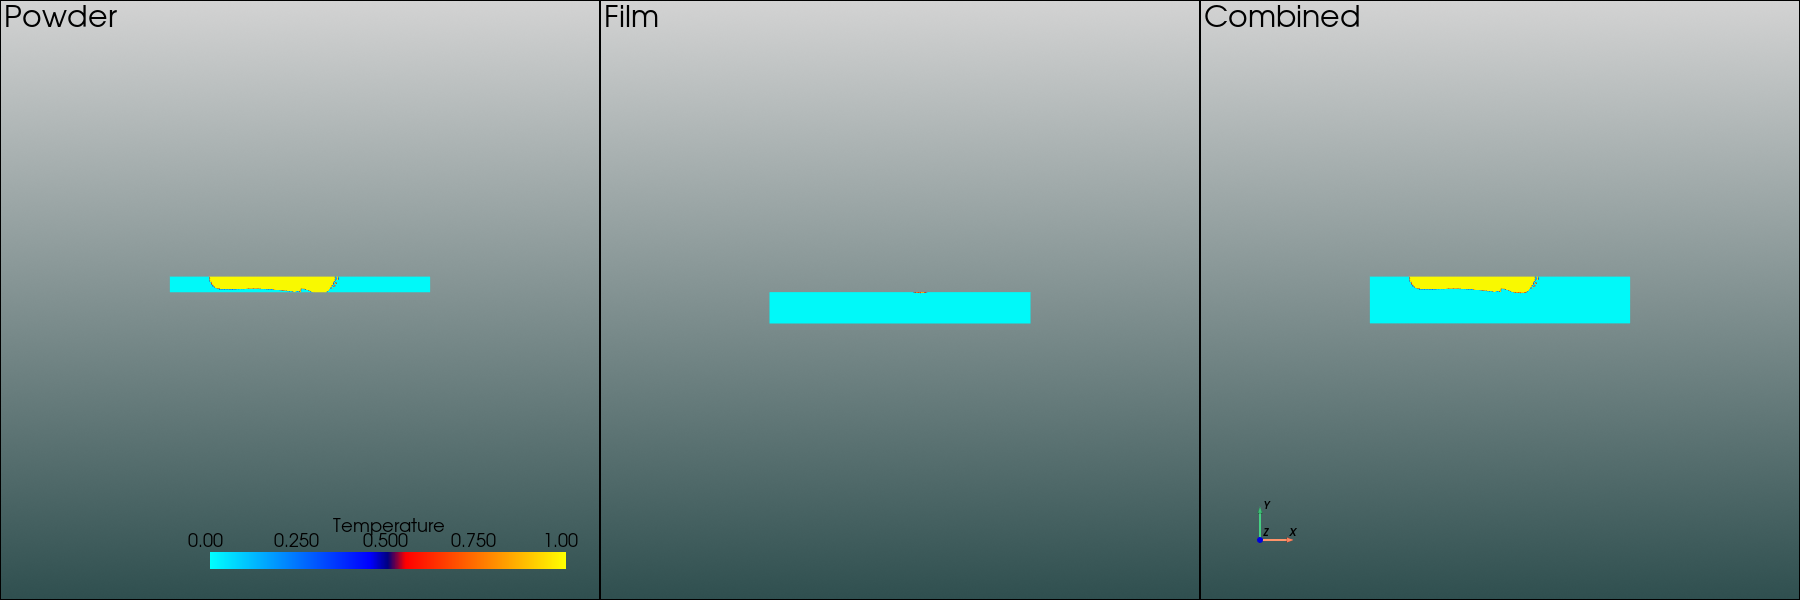

In [18]:
timestep = 1300
variable_t = variable_data[timestep, :]

# Assign nodal temperature to meshes
grid_powder["Temperature"] = variable_t
grid_film["Temperature"]   = variable_t

cmap = cold2hot #'rainbow'

# --- Plot side-by-side ---
plotter = pv.Plotter(shape=(1,3))

plotter.subplot(0,0)
plotter.add_mesh(grid_powder, scalars="Temperature", cmap=cmap)
plotter.add_text("Powder", font_size=12)
plotter.view_vector([0.0, 0.0, 1.0], viewup=[0,0,0]) 

plotter.subplot(0,1)
plotter.add_mesh(grid_film, scalars="Temperature", cmap=cmap)
plotter.add_text("Film", font_size=12)
plotter.view_vector([0.0, 0.0, 1.0], viewup=[0,0,0]) 


plotter.subplot(0,2)
plotter.add_mesh(grid_powder, scalars="Temperature", cmap=cmap)
plotter.subplot(0,2)
plotter.add_mesh(grid_film, scalars="Temperature", cmap=cmap)
plotter.add_text("Combined", font_size=12)
plotter.view_vector([0.0, 0.0, 1.0], viewup=[0,0,0]) 


plotter.set_background("darkslategray", top="lightgray")
plotter.enable_3_lights()
plotter.show_axes()


plotter.show(window_size=(1800,600), jupyter_backend='static')